
Data Dictionary and Overview (from Kaggle https://www.kaggle.com/datasets/udaymalviya/bank-loan-data?resource=download)

This dataset contains 45,000 records of loan applicants, with various attributes related to personal demographics, financial status, and loan details.

Personal Information

- person_age: Age of the applicant (in years).

- person_gender: Gender of the applicant (male, female).

- person_education: Educational background (High School, Bachelor, Master, etc.).

- person_income: Annual income of the applicant (in USD).

- person_emp_exp: Years of employment experience.

- person_home_ownership: Type of home ownership (RENT, OWN, MORTGAGE).


Loan Details

- loan_amnt: Loan amount requested (in USD).

- loan_intent: Purpose of the loan (PERSONAL, EDUCATION, MEDICAL, etc.).

- loan_int_rate: Interest rate on the loan (percentage).

- loan_percent_income: Ratio of loan amount to income.


Credit & Loan History

- cb_person_cred_hist_length: Length of the applicant"s credit history (in years).

- credit_score: Credit score of the applicant.

- previous_loan_defaults_on_file: Whether the applicant has previous loan defaults (Yes or No).



Target Variable

- loan_status: 1 if the loan was repaid successfully, 0 if the applicant defaulted.


In [37]:
import pandas as pd

df = pd.read_csv("loan_data.csv")

# Display basic dataset information
print('Shape of the dataset:', df.shape)

# See if there are rows with nulls that need to be removed
rows_with_nulls = df.isna().any(axis=1).sum()
print(f"Number of rows with null values: {rows_with_nulls}")

# No nulls so we are fine

# If there are duplicates, we remove them
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print('Duplicates dropped.')

Shape of the dataset: (45000, 14)
Number of rows with null values: 0


In [17]:
# View df
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [16]:
# Step 2 Some basic EDA
print(df.describe(include="all"))

          person_age person_gender person_education  person_income  \
count   45000.000000         45000            45000   4.500000e+04   
unique           NaN             2                5            NaN   
top              NaN          male         Bachelor            NaN   
freq             NaN         24841            13399            NaN   
mean       27.764178           NaN              NaN   8.031905e+04   
std         6.045108           NaN              NaN   8.042250e+04   
min        20.000000           NaN              NaN   8.000000e+03   
25%        24.000000           NaN              NaN   4.720400e+04   
50%        26.000000           NaN              NaN   6.704800e+04   
75%        30.000000           NaN              NaN   9.578925e+04   
max       144.000000           NaN              NaN   7.200766e+06   

        person_emp_exp person_home_ownership     loan_amnt loan_intent  \
count     45000.000000                 45000  45000.000000       45000   
unique     

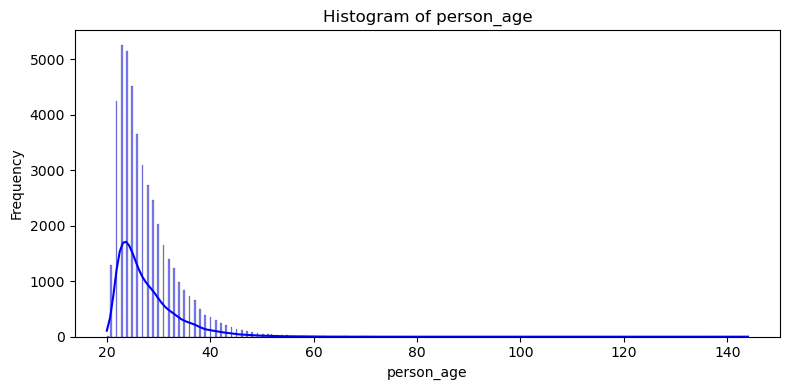

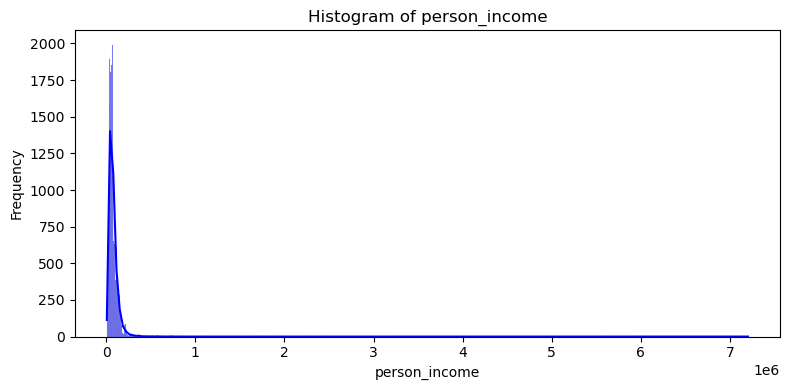

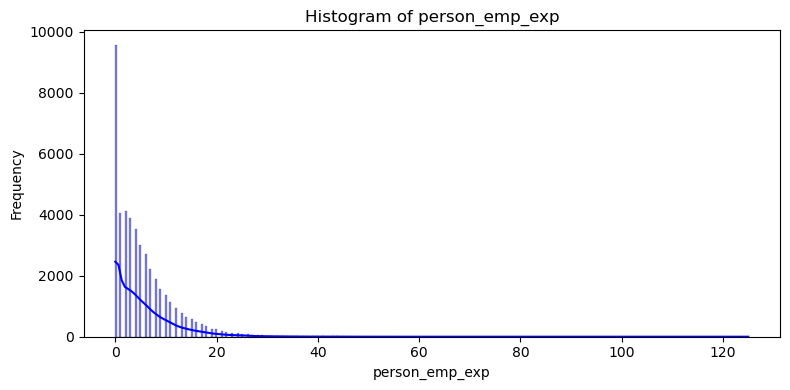

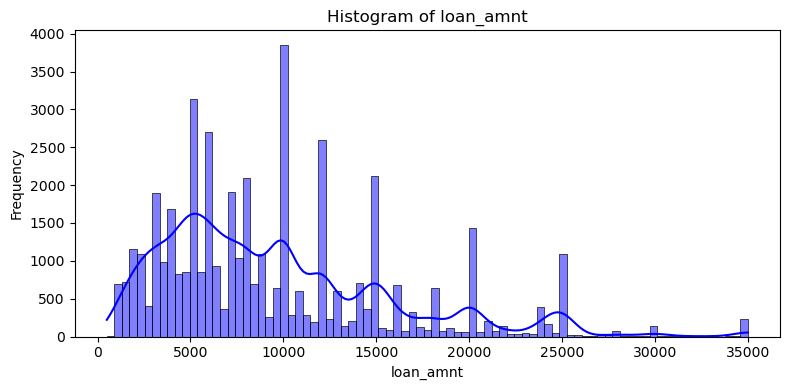

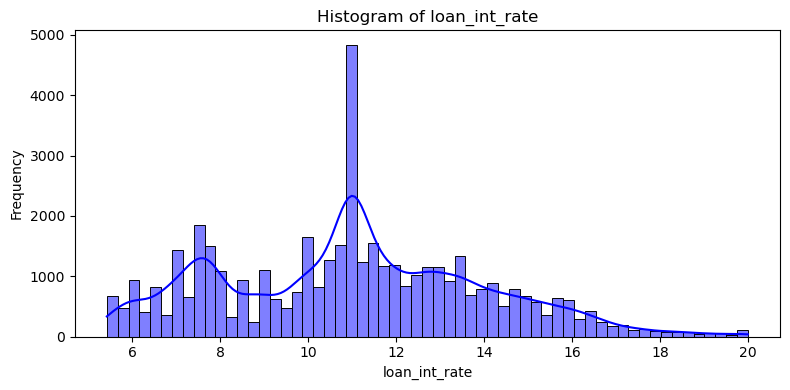

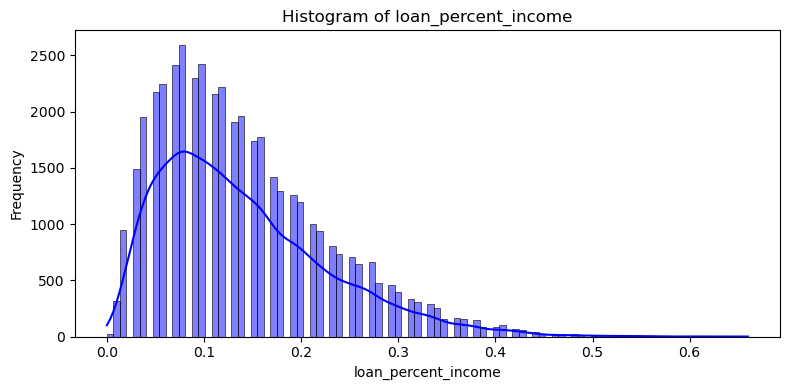

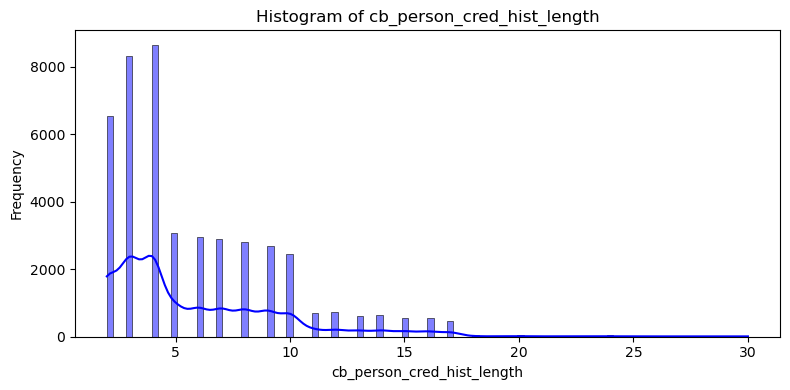

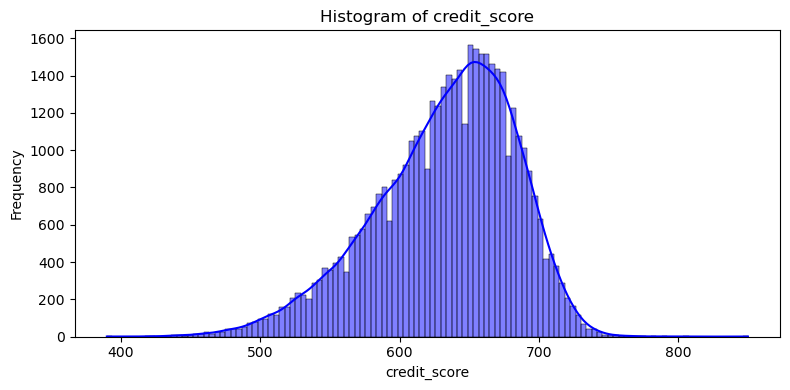

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df[["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

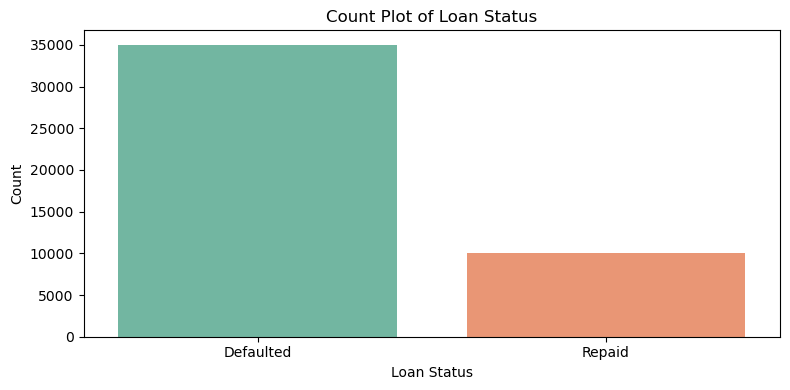

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, x='loan_status', palette='Set2')

# Rename x-axis tick labels
ax.set_xticklabels(['Defaulted', 'Repaid'])

plt.title('Count Plot of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

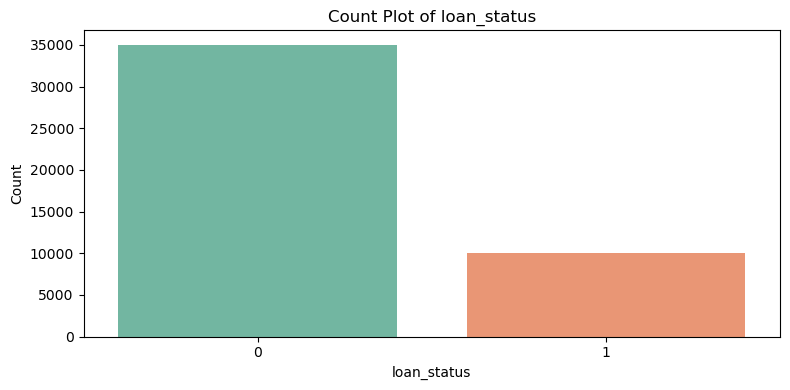

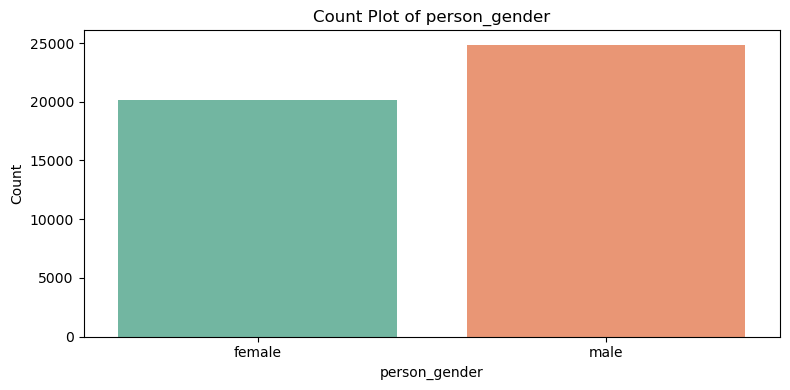

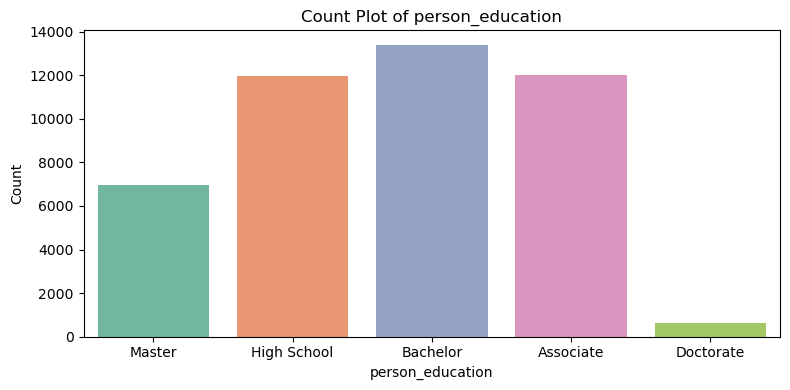

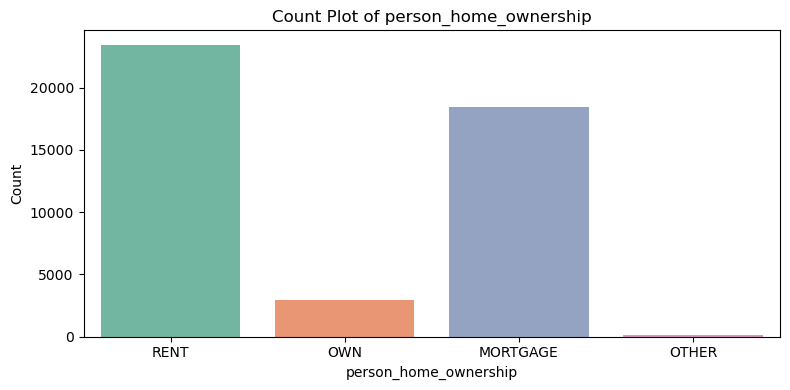

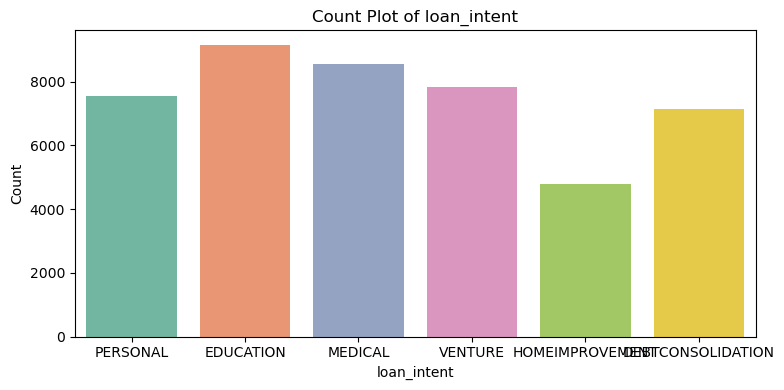

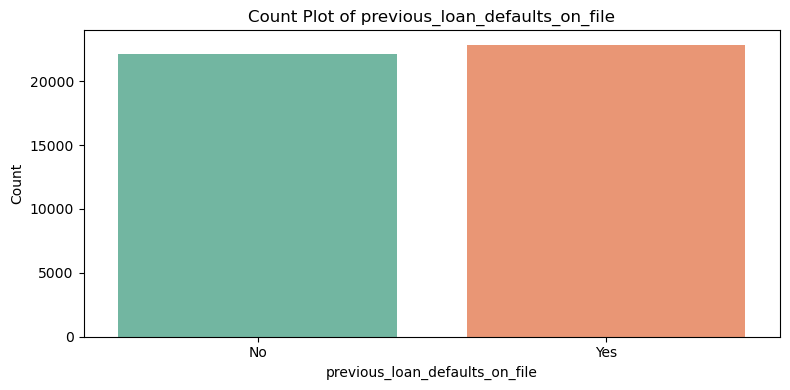

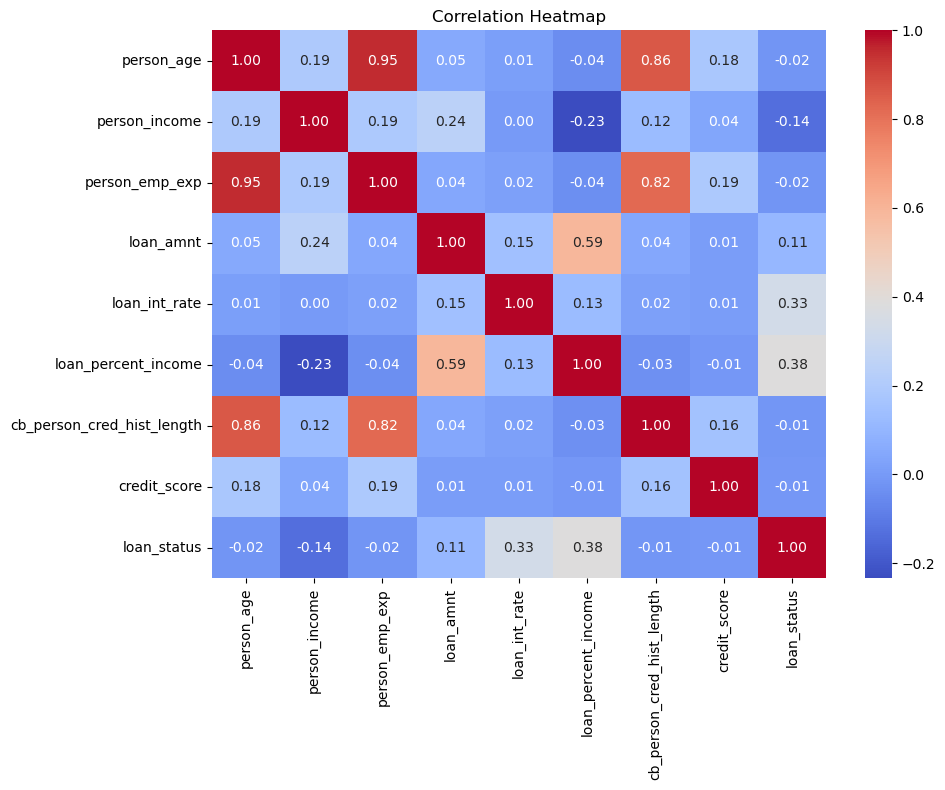

ValueError: Boolean array expected for the condition, not float64

In [ ]:
# Plotting count plots for key categorical columns
for col in ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Correlation heatmap if there are 4 or more numeric columns
if len(numeric_cols) >= 4:
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Pair plot to observe relationships among numeric features
sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.show()

Explained variance ratio: [0.3189796  0.20938393]


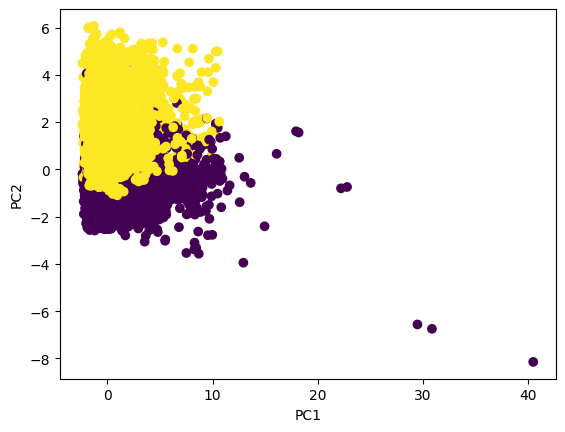

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['loan_status'].astype('category').cat.codes)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show() 

In [47]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import kl_div

def compute_kl_divergence(df, feature, target_class, eps=1e-10):
    # Get data for each class
    class_0 = df[df[target_class] == 0][feature].dropna()
    class_1 = df[df[target_class] == 1][feature].dropna()
    
    # Estimate PDFs using KDE
    kde0 = gaussian_kde(class_0)
    kde1 = gaussian_kde(class_1)
    
    # Evaluate on common range
    x = np.linspace(
        min(class_0.min(), class_1.min()),
        max(class_0.max(), class_1.max()), 
        1000
    )
    p = kde0(x) + eps
    q = kde1(x) + eps
    
    # Calculate KL(P||Q)
    kl_pq = np.sum(kl_div(p, q))
    
    return kl_pq

KL Divergence (credit_score): 0.0039


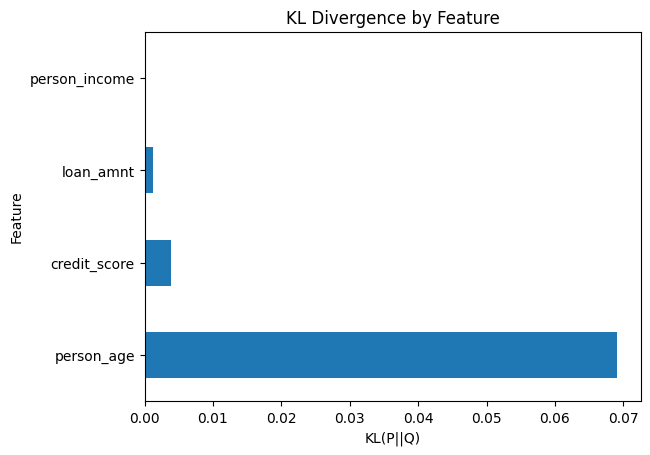

In [48]:
# Compute KL divergence for 'credit_score'
kl_credit = compute_kl_divergence(df, 'credit_score', 'loan_status')
print(f"KL Divergence (credit_score): {kl_credit:.4f}")

# Compare multiple features
features = ['credit_score', 'person_income', 'loan_amnt', 'person_age']
kl_results = {f: compute_kl_divergence(df, f, 'loan_status') for f in features}

pd.Series(kl_results).sort_values(ascending=False).plot(kind='barh')
plt.title("KL Divergence by Feature")
plt.xlabel("KL(P||Q)"); plt.ylabel("Feature")
plt.show()

In [18]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Step 3 Preprocess

# Convert yes no column to boolean
loans_bool = (np.where(df["previous_loan_defaults_on_file"] == "Yes", True, False)).reshape(-1, 1)

# Seperate out dependent variable
y = df["loan_status"]


# Numerical Variables
numerical = df[["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]]

# Min Max scale numerical data
scaler = preprocessing.MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)


# Categorical Variables
categorical = df[["person_gender", "person_education", "person_home_ownership", "loan_intent"]]
categorical_dummies = pd.get_dummies(categorical, drop_first=True)
categorical_dummies_array = np.array(categorical_dummies)

# Column names / order
columns = list(numerical.columns) + list(categorical_dummies.columns) + ["previous_loan_defaults_on_file"]

# Create Phi with numerical, categorical, and boolean variables
Phi = np.hstack((numerical_scaled, categorical_dummies_array, loans_bool))

print(f"Number of columns after preprocessing: {Phi.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(Phi, y, test_size=0.2, random_state=23)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

Number of columns after preprocessing: 22


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [20]:
# KNN
def run_knn(X_train, y_train, X_test, y_test, k):
    predictions = []

    for test_point in X_test:
        # L2 distances
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))

        # K nearest neighbors
        knn_indices = np.argsort(distances)[:k]
        knn_labels = y_train[knn_indices]

        # Calculate mode
        unique_values, counts = np.unique(knn_labels, return_counts=True)
        mode_index = np.argmax(counts)
        predicted_class = unique_values[mode_index]

        predictions.append(predicted_class)

    # Prediction accuracy
    y_pred = np.array(predictions)
    accuracy = np.mean(y_pred == y_test)
    return accuracy, y_pred

K = 5, Accuracy: 0.8881
K = 10, Accuracy: 0.8914
K = 25, Accuracy: 0.8950
K = 50, Accuracy: 0.8909
K = 75, Accuracy: 0.8854
K = 100, Accuracy: 0.8742
K = 125, Accuracy: 0.8697
K = 150, Accuracy: 0.8629
K = 175, Accuracy: 0.8650
K = 190, Accuracy: 0.8632
K = 200, Accuracy: 0.8626
K = 225, Accuracy: 0.8639
K = 250, Accuracy: 0.8657


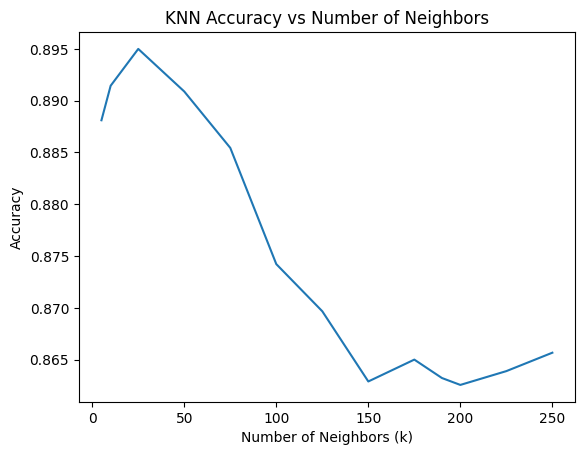

In [21]:
# Params
n = X_train.shape[0]
sqrt_n = int(np.sqrt(n).round())  # 190

k_values = [5, 10, 25, 50, 75, 100, 125, 150, 175, sqrt_n, 200, 225, 250]   # Some test ks


# Run KNN for different k values in a for loop
accuracies = []
for k in k_values:
    accuracy, y_pred = run_knn(X_train, y_train, X_test, y_test, k)
    accuracies.append(accuracy)
    print(f"K = {k}, Accuracy: {accuracy:.4f}")

# Plot k vs accuracy
plt.plot(k_values, accuracies)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs Number of Neighbors")
plt.show()

In [ ]:
# Best k was 25
k = 25
accuracy, predictions = run_knn(X_train, y_train, X_test, y_test, k)
y_pred = np.array(predictions)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6995
           1       0.83      0.66      0.74      2005

    accuracy                           0.90      9000
   macro avg       0.87      0.81      0.84      9000
weighted avg       0.89      0.90      0.89      9000



The best k was clearly 25 (though this is also very dependent on the random state), and the results were decently strong with an accuracy of 90% correct predictions. There is clearly a strong class imbalance with more 0s than 1s, and the model is not handling that very well with significantly lower prediction accuracies for predicting a 1 than a 0. This could potentially be improved by imputing some dummy data points.

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# We can use the same train test as scaling should not matter for random forest

rf = RandomForestClassifier(max_depth=None, random_state=23, criterion="entropy")

# Train the model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Feature importance
feature_importance = rf.feature_importances_
feature_names = [f"Feature {i}" for i in range(Phi.shape[1])]

# Make feature importance and display top 10
importance_df = pd.DataFrame({"Feature": columns, "Importance": feature_importance})
importance_df = importance_df.sort_values("Importance", ascending=False)
print("\nFeature Importance:")
print(importance_df.head(10))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6995
           1       0.89      0.75      0.82      2005

    accuracy                           0.92      9000
   macro avg       0.91      0.86      0.88      9000
weighted avg       0.92      0.92      0.92      9000


Feature Importance:
                           Feature  Importance
21  previous_loan_defaults_on_file    0.282684
4                    loan_int_rate    0.140735
5              loan_percent_income    0.138140
1                    person_income    0.114161
3                        loan_amnt    0.060077
7                     credit_score    0.052864
15      person_home_ownership_RENT    0.047594
0                       person_age    0.032111
2                   person_emp_exp    0.028384
6       cb_person_cred_hist_length    0.026366


The model does better at predicting 0s (defaulting the loan) than 1s (completing the payment). This is likely due to a strong class imbalance with more 0s than 1s in the dataset. Despite the strong imbalance, the model results were relatively good with an accuracy of 93% correct predictions. The model is clearly better than the knn, and significantly outperforms it for predicting 1s.

The most important features that provided the best splits were the persons yearly income, the loan percent of the income, the loan interest rate, and by far if the person had previous loan defaults on file. These all make a lot of sense as they seem incredibly relevant to the prediction. All of these statistics are very strongly correlated, so I wonder if they are not all necessary in a simplified model.

In [42]:
# Logistic Regression
def sigmoid(x, w):
    return 1/(1 + np.exp(-x.T.dot(w)))

def logistic_grad(X, y, w):
    L = 0
    for i, j in enumerate(X):
        x = j.reshape(X.shape[1], 1)
        L += (sigmoid(x, w) - y[i])*x

    dL_dw = L/len(X)
    return dL_dw

def gradient_descent(X, y, w, eta, epochs):
    for i in range(epochs):
        w = w - eta*logistic_grad(X, y, w)
    return w

In [46]:
# New train test split with intercept column
Phi = np.hstack((numerical_scaled, categorical_dummies_array, loans_bool, np.ones(numerical_scaled.shape[0]).reshape(-1, 1)))

print(f"Number of columns after preprocessing: {Phi.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(Phi, y, test_size=0.2, random_state=23)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Params
w0 = np.ones(X_train.shape[1]).reshape(-1, 1)
eta = 0.1
epochs = 1000

# Run Gradient Descent to (hopefully) improve predictions
w_gd = gradient_descent(X_train, y_train, w0, eta, epochs)

Number of columns after preprocessing: 23


In [47]:
# Evaluate logistic regression model
preds = []
for i in range(X_test.shape[0]):
    preds.append(int(sigmoid(X_test[i,:], w_gd)[0] > .5))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, preds))

columns_with_intercept = columns + ["intercept"]
# Create and sort importance dataframe
importance_df = pd.DataFrame({"Feature": columns_with_intercept, "Weight": w_gd.reshape(-1), "Abs Weight": np.abs(w_gd.reshape(-1))})
importance_df = importance_df.sort_values("Abs Weight", ascending=False)
print(importance_df)
# print(w_gd)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      6995
           1       0.79      0.68      0.73      2005

    accuracy                           0.89      9000
   macro avg       0.85      0.81      0.83      9000
weighted avg       0.88      0.89      0.88      9000

                           Feature    Weight  Abs Weight
21  previous_loan_defaults_on_file -3.256149    3.256149
22                       intercept -1.649544    1.649544
5              loan_percent_income  1.154655    1.154655
13     person_home_ownership_OTHER  0.978011    0.978011
4                    loan_int_rate  0.920900    0.920900
15      person_home_ownership_RENT  0.860771    0.860771
10      person_education_Doctorate  0.820023    0.820023
17     loan_intent_HOMEIMPROVEMENT  0.683390    0.683390
18             loan_intent_MEDICAL  0.502514    0.502514
3                        loan_amnt -0.490486    0.490486
7                     

In [27]:
# Scaling data differently for LDA, PCA, and SVM
from sklearn.preprocessing import StandardScaler

# Standard scale numerical data
scaler =  StandardScaler()
numerical_scaled = scaler.fit_transform(numerical)


# Create Phi with numerical, categorical, and boolean variables
Phi_standard = np.hstack((numerical_scaled, categorical_dummies_array, loans_bool))

print(f"Number of columns after preprocessing: {Phi_standard.shape[1]}")

X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(Phi_standard, y, test_size=0.2, random_state=23)
X_train_standard, y_train_standard, X_test_standard, y_test_standard = np.array(X_train_standard), np.array(y_train_standard), np.array(X_test_standard), np.array(y_test_standard)

Number of columns after preprocessing: 22



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6995
           1       0.76      0.75      0.75      2005

    accuracy                           0.89      9000
   macro avg       0.84      0.84      0.84      9000
weighted avg       0.89      0.89      0.89      9000



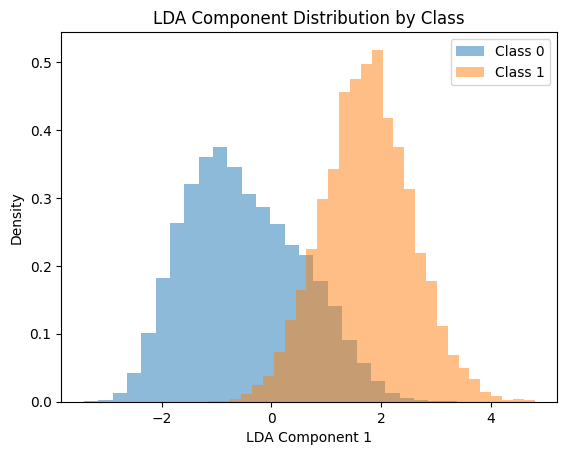

In [28]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 2d space
lda = LinearDiscriminantAnalysis(n_components=1)

# Train model
lda.fit(X_train_standard, y_train_standard)

# Predict on the Test Set
y_pred = lda.predict(X_test_standard)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

X_transformed = lda.transform(Phi_standard)

# Plot
for class_value in np.unique(y):
    class_data = X_transformed[y == class_value]
    plt.hist(class_data, alpha=0.5, bins=30, density=True, 
             label=f'Class {class_value}')
plt.xlabel("LDA Component 1")
plt.ylabel("Density")
plt.title("LDA Component Distribution by Class")
plt.legend()

Because it is a binary classification, we only can have one component as there is only one hyperplane division to split the components. There is some clear overlap, which is expected, but the model does a surprisingly strong job seperating the data on just one hyperplane. Would be interesting to see if SVM has a similar division.

In [29]:
# SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_standard, y_train_standard)

# Predict on test
y_pred = svm.predict(X_test_standard)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6995
           1       0.78      0.74      0.76      2005

    accuracy                           0.90      9000
   macro avg       0.85      0.84      0.85      9000
weighted avg       0.89      0.90      0.89      9000



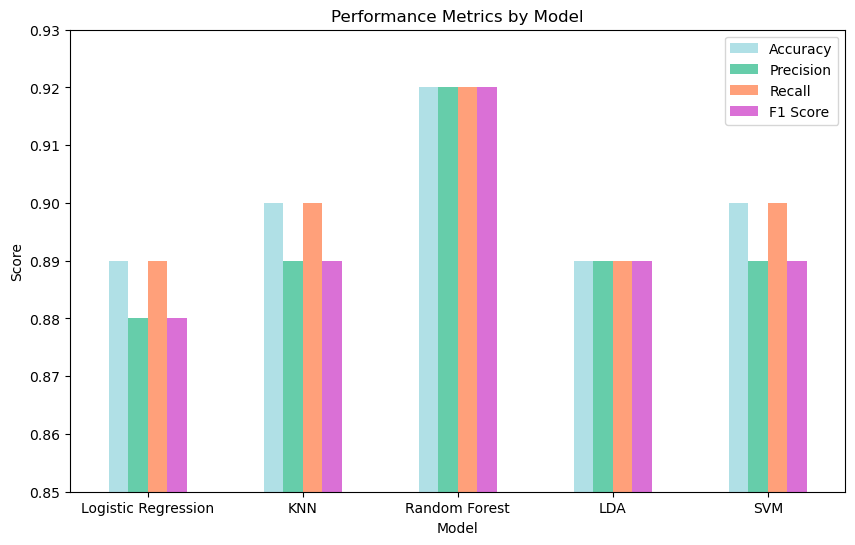

In [61]:
# Dataframe of model scores
data = {
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'LDA', 'SVM'],
    'Accuracy': [0.89, 0.90, 0.92, 0.89, 0.90],
    'Precision': [0.88, 0.89, 0.92, 0.89, 0.89],
    'Recall': [0.89, 0.90, 0.92, 0.89, 0.90],
    'F1 Score': [0.88, 0.89, 0.92, 0.89, 0.89]
}
colors = ['powderblue', 'mediumaquamarine', 'lightsalmon', 'orchid']
df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.ylim(0.85, 0.93)
plt.ylabel('Score')
plt.title('Performance Metrics by Model')
plt.xticks(rotation=0)
plt.show()
